### **Importing the requited Libraries**

In [2]:
import pandas as pd
import numpy as np
import warnings
import joblib
import pickle
import seaborn as sns
from keras.layers import Dense
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from keras.models import Sequential
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from scikeras.wrappers import KerasClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score,\
    recall_score, precision_score, confusion_matrix

### **Loading raw data, split  it, then process it**

In [3]:
# Suppress warnings
warnings.filterwarnings("ignore")

# Load data
heart_data = pd.read_csv("../data/processed/heart_cleaned_data.csv")

# Define features and target
numerical_features = ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']
categorical_features = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
target_variable = 'HeartDisease'

# Splitting the data
X = heart_data[numerical_features + categorical_features]
y = heart_data[target_variable]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=67)

# Preprocessing for numerical and categorical features
numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])
categorical_transformer = Pipeline(steps=[("onehot", OneHotEncoder(handle_unknown="ignore"))])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

### **Helper function that plot best model evaluation**

In [4]:
def plot_model_evaluation(model_name, y_test, y_pred, y_pred_prob, test_accuracy, precision, recall, output_dir="../reports"):
    """
    Generate evaluation plots for each model.

    Parameters:
    - model_name (str): Name of the model (e.g., "KNN", "Neural Network").
    - y_test (array-like): True labels of the test set.
    - y_pred (array-like): Predicted classes of the model.
    - y_pred_prob (array-like): Predicted probabilities of the positive class.
    - test_accuracy (float): Accuracy score of the model.
    - precision (float): Precision score of the model.
    - recall (float): Recall score of the model.
    - output_dir (str): Directory to save the plots (default: "../reports").
    """

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    auc_score = roc_auc_score(y_test, y_pred_prob)

    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc_score:.4f}, Accuracy = {test_accuracy:.4f})")
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
    plt.title(f"{model_name}: ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.savefig(f"{output_dir}/{model_name}_ROC_Curve.png")
    plt.show()

    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Heart Disease', 'Heart Disease'],
                yticklabels=['No Heart Disease', 'Heart Disease'])
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(f"{output_dir}/{model_name}_Confusion_Matrix.png")
    plt.show()

    # Bar Plot for Accuracy, Precision, and Recall
    metrics = [test_accuracy, precision, recall]
    metric_names = ['Accuracy', 'Precision', 'Recall']

    plt.figure(figsize=(8, 6))
    plt.barh(metric_names, metrics, color=['green', 'orange', 'skyblue'])
    plt.title(f'{model_name}: Accuracy, Recall, and Precision')
    plt.xlabel('Scores')
    plt.savefig(f"{output_dir}/{model_name}_Scores.png")
    plt.show()


## **1 - Random Forest**

Best Parameters Found:
{'classifier__max_depth': None, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 100}
Test Accuracy: 0.9348
Precision: 0.9223
Recall: 0.9596
AUC Score: 0.9816


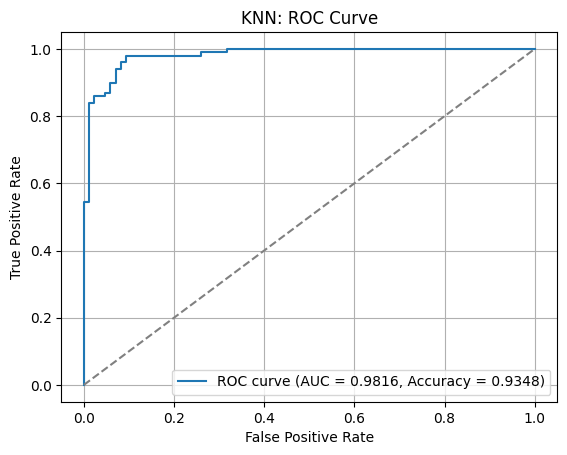

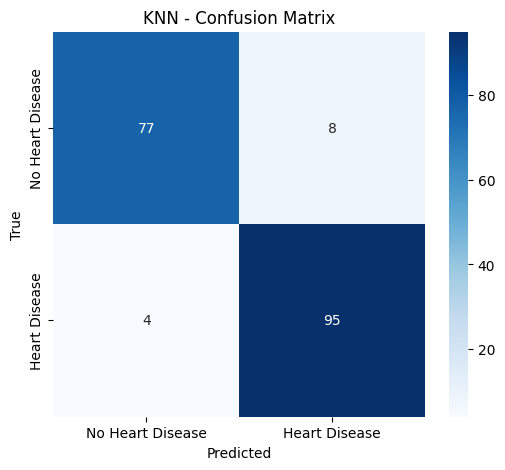

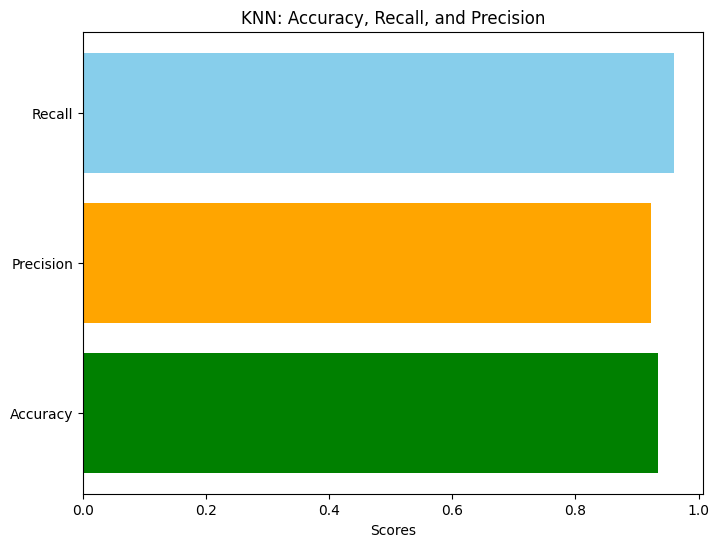

Best model saved as 'best_rf_model.pkl'


In [5]:
# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=67)

# Create a pipeline
pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", rf_classifier)])

# Define parameter grid for Random Forest
param_grid = {
    'classifier__n_estimators': [50, 100, 200],  # Number of trees
    'classifier__max_depth': [None, 10, 20, 30],  # Maximum depth of trees
    'classifier__min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
    'classifier__min_samples_leaf': [1, 2, 4],    # Minimum samples required at leaf node
}

# Grid search for best parameters
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', return_train_score=True)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Best parameters found
print("Best Parameters Found:")
print(grid_search.best_params_)

# Best model based on grid search
best_rf_model = grid_search.best_estimator_


y_pred = best_rf_model.predict(X_test)

# Test accuracy on the best model
test_accuracy = accuracy_score(y_test, best_rf_model.predict(X_test))
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate precision and recall
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Calculate AUC for the best model
y_pred_prob = best_rf_model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_pred_prob)
print(f"AUC Score: {auc_score:.4f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)


# Plot confusion matrix, AUC_ROC, (accuracy, recall, and precision) for the best model
plot_model_evaluation(
    model_name="KNN",
    y_test=y_test,
    y_pred=y_pred,
    y_pred_prob=y_pred_prob,
    test_accuracy=test_accuracy,
    precision=precision,
    recall=recall
)

# Save the best model using pickle
with open('../models/best_rf_model.pkl', 'wb') as file:
    joblib.dump(best_rf_model, file)
    print("Best model saved as 'best_rf_model.pkl'")
    
  

## **2 - Logistic Regression**

Best Parameters Found:
{'classifier__C': 0.23357214690901212, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Test Accuracy: 0.9076
Precision: 0.9271
Recall: 0.8990
AUC Score: 0.9697


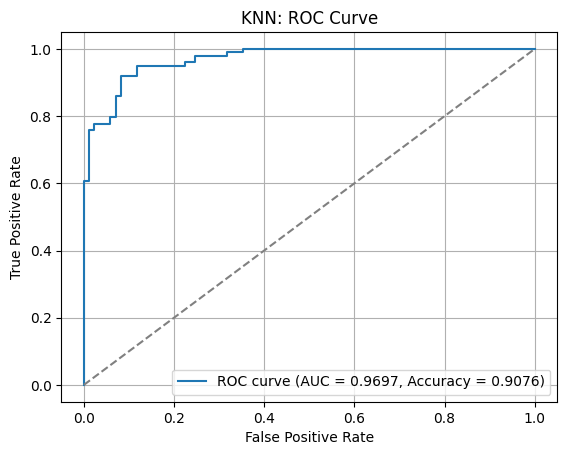

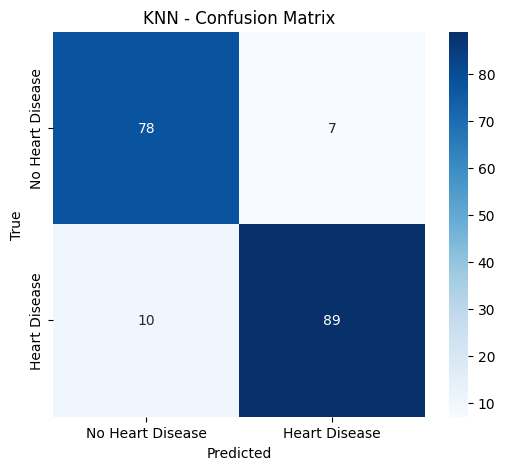

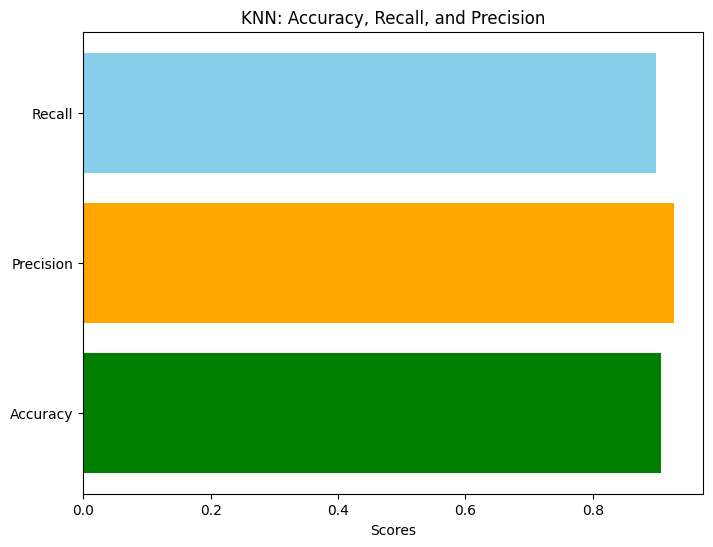

Best model saved as 'best_logreg_model.pkl'


In [6]:

# Create a Logistic Regression classifier
logreg = LogisticRegression(max_iter=1000)

# Create a pipeline
pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", logreg)])

# Define parameter grid for Logistic Regression
param_grid = {
    'classifier__C': np.logspace(-4, 4, 20),  # Regularization strength (inverse of C)
    'classifier__penalty': ['l2'],  # Regularization type
    'classifier__solver': ['liblinear', 'saga'],  # Solvers for optimization
}

# Grid search for best parameters
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', return_train_score=True)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Best parameters found
print("Best Parameters Found:")
print(grid_search.best_params_)

# Best model based on grid search
best_logreg_model = grid_search.best_estimator_

y_pred = best_logreg_model.predict(X_test)


# Test accuracy on the best model
test_accuracy = accuracy_score(y_test, best_logreg_model.predict(X_test))
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate precision and recall
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Calculate AUC for the best model
y_pred_prob = best_logreg_model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_pred_prob)
print(f"AUC Score: {auc_score:.4f}")


# Plot confusion matrix, AUC_ROC, (accuracy, recall, and precision) for the best model
plot_model_evaluation(
    model_name="KNN",
    y_test=y_test,
    y_pred=y_pred,
    y_pred_prob=y_pred_prob,
    test_accuracy=test_accuracy,
    precision=precision,
    recall=recall
)

# Save the best model using pickle  
with open('../models/best_logreg_model.pkl', 'wb') as file:
    joblib.dump(best_logreg_model, file)
    print("Best model saved as 'best_logreg_model.pkl'")
    
  

## **3 - KNN**

Best Parameters Found:
{'classifier__metric': 'euclidean', 'classifier__n_neighbors': 20, 'classifier__weights': 'distance'}
Test Accuracy: 0.9130
Precision: 0.9192
Recall: 0.9192
AUC Score: 0.9725


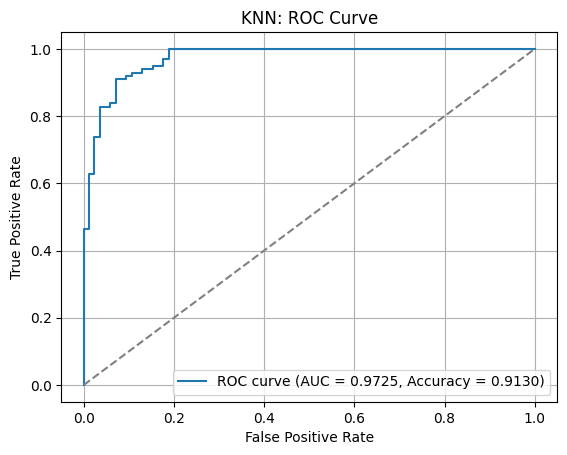

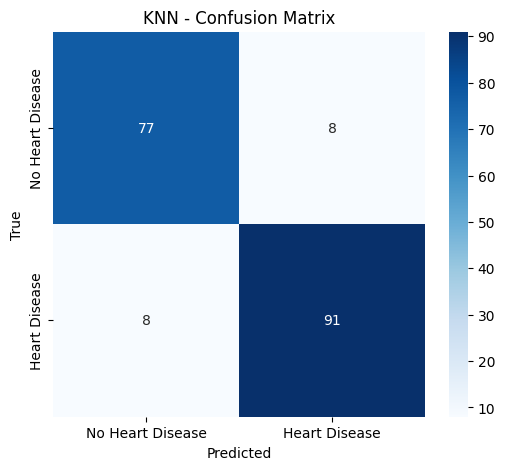

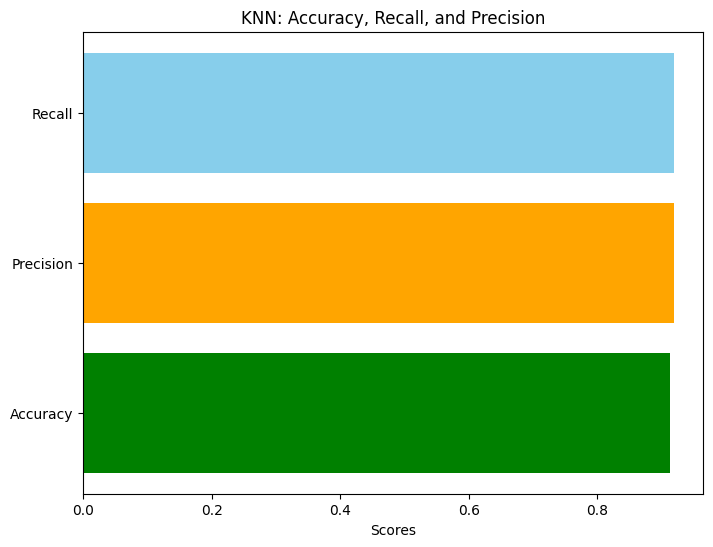

Best model saved as 'best_knn_model.pkl'


In [7]:
# Create a KNN classifier
knn = KNeighborsClassifier()

# Create a pipeline
pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", knn)])

# Define parameter grid for KNN classifier
param_grid = {
    'classifier__n_neighbors': np.arange(2, 50, 2),  # Varying n_neighbors
    'classifier__weights': ['uniform', 'distance'],  # Varying the weights
    'classifier__metric': ['euclidean', 'manhattan'],  # Different distance metrics
}

# Grid search for best parameters
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', return_train_score=True)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Best parameters found
print("Best Parameters Found:")
print(grid_search.best_params_)

# Best model based on grid search
best_knn_model = grid_search.best_estimator_

# Test predictions
y_pred = best_knn_model.predict(X_test)

# Test accuracy on the best model
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate precision and recall
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Calculate AUC for the best model
y_pred_prob = best_knn_model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_pred_prob)
print(f"AUC Score: {auc_score:.4f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

plot_model_evaluation(
    model_name="KNN",
    y_test=y_test,
    y_pred=y_pred,
    y_pred_prob=y_pred_prob,
    test_accuracy=test_accuracy,
    precision=precision,
    recall=recall
)

# Save the best model using pickle
with open('../models/best_knn_model.pkl', 'wb') as file:
    joblib.dump(best_knn_model, file)
    print("Best model saved as 'best_knn_model.pkl'")
    

## **4 - NEURAL NETWORK**

Best Parameters Found:
{'classifier__batch_size': 32, 'classifier__epochs': 50}
Test Accuracy: 0.9076
Precision: 0.9020
Recall: 0.9293
AUC Score: 0.9716


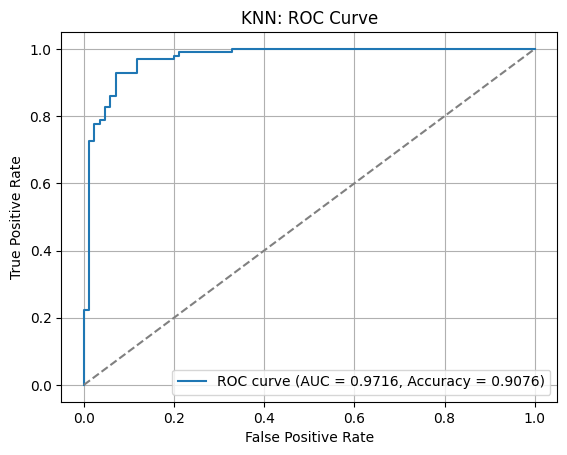

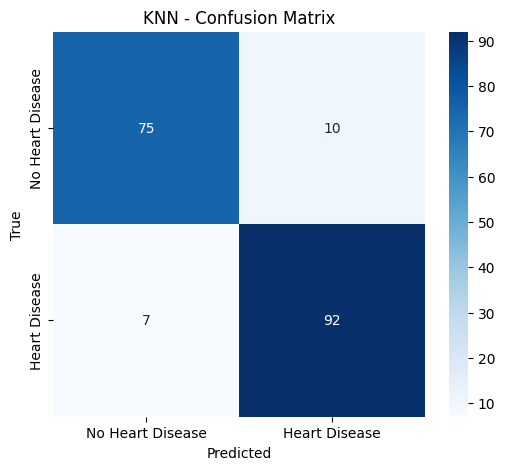

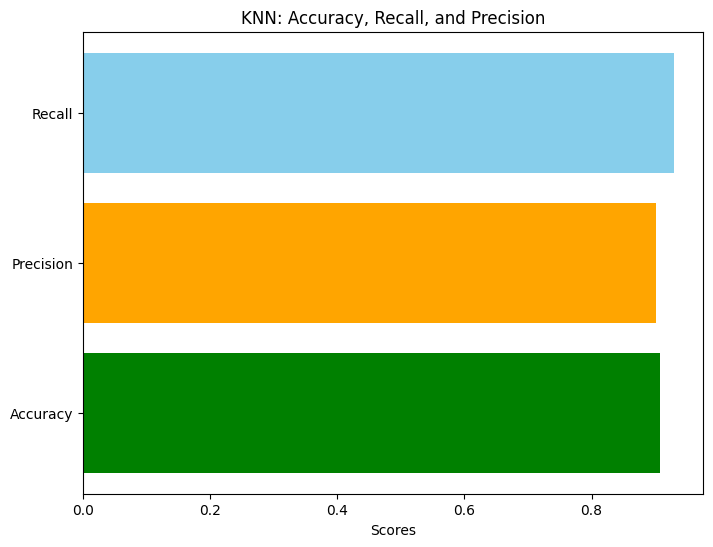

INFO:tensorflow:Assets written to: C:\Users\user\AppData\Local\Temp\tmpgzauwdv2\assets


INFO:tensorflow:Assets written to: C:\Users\user\AppData\Local\Temp\tmpgzauwdv2\assets


Best model saved as 'best_nn_model.pkl'


In [9]:
# To get the correct number of input features after one-hot encoding
X_train_transformed = preprocessor.fit_transform(X_train)
input_dim = X_train_transformed.shape[1]  # Number of features after preprocessing

# Function to create the Sequential model
def create_nn_model(hidden_layer_sizes=(128,)):
    model = Sequential()
    # Add input layer (with number of features as input_dim)
    model.add(Dense(64, input_dim=input_dim, activation='relu'))  # First hidden layer
    for units in hidden_layer_sizes:
        model.add(Dense(units, activation='relu'))  # Additional hidden layers
    model.add(Dense(1, activation='sigmoid'))  # Output layer (binary classification)
    
    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Create a KerasClassifier wrapper for the neural network
nn_classifier = KerasClassifier(build_fn=create_nn_model, epochs=50, batch_size=32, verbose=0)

# Create a pipeline
pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", nn_classifier)])

# Define parameter grid for Neural Network
param_grid = {
    'classifier__epochs': [50, 100],  # Number of epochs for training
    'classifier__batch_size': [16, 32],  # Batch sizes
}

# Grid search for best parameters
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', return_train_score=True)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Best parameters found
print("Best Parameters Found:")
print(grid_search.best_params_)

# Best model based on grid search
best_nn_model = grid_search.best_estimator_


y_pred = best_nn_model.predict(X_test)


# Test accuracy on the best model
test_accuracy = accuracy_score(y_test, best_nn_model.predict(X_test))
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate precision and recall
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")


# Calculate AUC for the best model
y_pred_prob = best_nn_model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_pred_prob)
print(f"AUC Score: {auc_score:.4f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)


# Plot confusion matrix, AUC_ROC, (accuracy, recall, and precision) for the best model
plot_model_evaluation(
    model_name="KNN",
    y_test=y_test,
    y_pred=y_pred,
    y_pred_prob=y_pred_prob,
    test_accuracy=test_accuracy,
    precision=precision,
    recall=recall
)

# Save the best model using pickle  
with open('../models/best_nn_model.pkl', 'wb') as file:
    joblib.dump(best_nn_model, file)
    print("Best model saved as 'best_nn_model.pkl'")

## **Comparison: selecting the best model ammong the four best models**

Best Model: Random Forest
Metrics: {'accuracy': 0.9347826086956522, 'precision': 0.9223300970873787, 'recall': 0.9595959595959596, 'auc_score': 0.9815805109922757, 'confusion_matrix': array([[77,  8],
       [ 4, 95]], dtype=int64)}


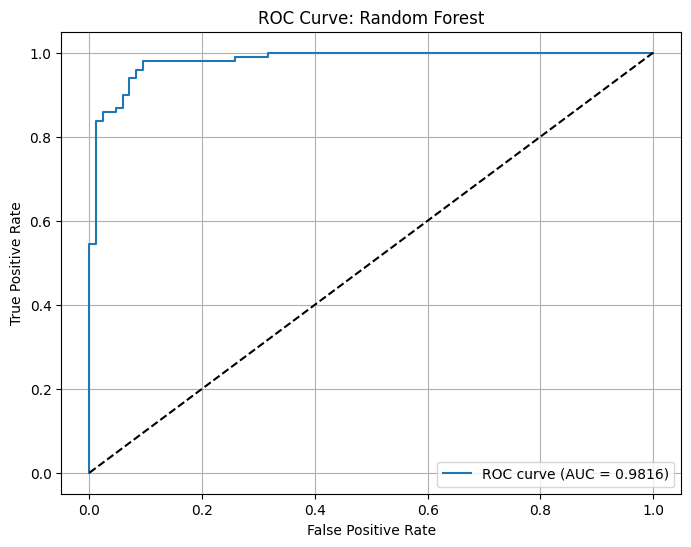

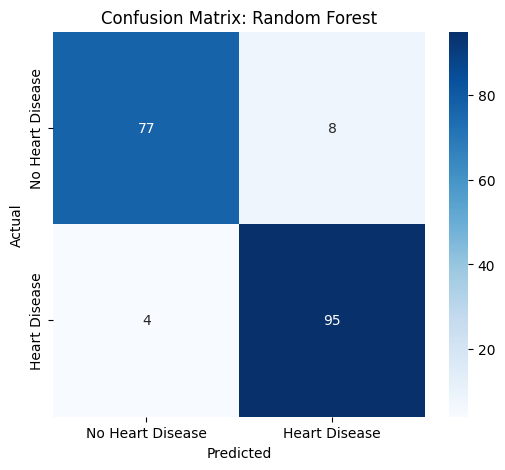

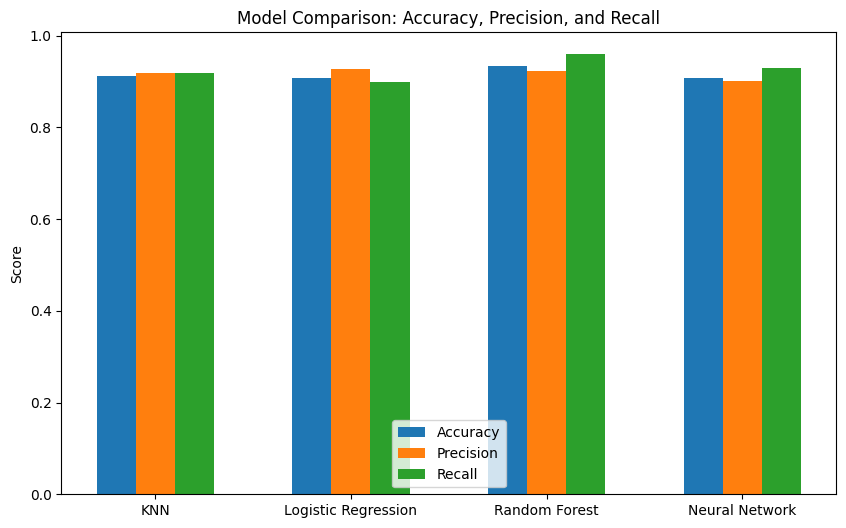

In [10]:


# Function to load models from .pkl files
def load_model(filepath):
    with open(filepath, 'rb') as file:
        model = pickle.load(file)
    return model

# Load the models
models = {
    "KNN": joblib.load("../models/best_knn_model.pkl"),
    "Logistic Regression": joblib.load("../models/best_logreg_model.pkl"),
    "Random Forest": joblib.load("../models/best_rf_model.pkl"),
    "Neural Network": joblib.load("../models/best_nn_model.pkl")
}



# Evaluate each model
model_metrics = {}
for model_name, model in models.items():
    # Predict and evaluate metrics
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred_prob) if y_pred_prob is not None else None

    model_metrics[model_name] = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "auc_score": auc_score,
        "confusion_matrix": confusion_matrix(y_test, y_pred)
    }

# Determine the best model based on accuracy
best_model_name = max(model_metrics, key=lambda name: model_metrics[name]['accuracy'])
best_model = models[best_model_name]
best_metrics = model_metrics[best_model_name]

print(f"Best Model: {best_model_name}")
print(f"Metrics: {best_metrics}")

# Plot AUC for the best model
if best_metrics['auc_score'] is not None:
    y_pred_prob = best_model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {best_metrics['auc_score']:.4f})")
    plt.plot([0, 1], [0, 1], 'k--')  # Random classifier line
    plt.title(f"ROC Curve: {best_model_name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid()
    plt.savefig("../reports/Best model_ROC Curve.png")
    plt.show()

# Plot confusion matrix for the best model
cm = best_metrics['confusion_matrix']
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Heart Disease', 'Heart Disease'], yticklabels=['No Heart Disease', 'Heart Disease'])
plt.title(f"Confusion Matrix: {best_model_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig("../reports/Best model_Confusion Matrix.png")
plt.show()

# Plot metrics for all models
metric_names = ['accuracy', 'precision', 'recall']
metrics_values = {metric: [model_metrics[model][metric] for model in models] for metric in metric_names}

plt.figure(figsize=(10, 6))
x = np.arange(len(models))
bar_width = 0.2

for i, metric in enumerate(metric_names):
    plt.bar(x + i * bar_width, metrics_values[metric], bar_width, label=metric.capitalize())

plt.xticks(x + bar_width, models.keys())
plt.ylabel("Score")
plt.title("Model Comparison: Accuracy, Precision, and Recall")
plt.legend()
plt.savefig("../reports/Models Comparison-Accuracy, Precision, and Recall.png")
plt.show()
